In [6]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
import os.path
import pandas as pd
import numpy as np
import matplotlib as mpl
import gc_colors
mpl.rcParams["figure.figsize"] = 15, 12
mpl.rcParams["lines.markeredgewidth"] = 1.0

# Function definitions

In [182]:
def get_medians(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    medians = []
    for block in datablocks:
        medians.append(np.median(block))
        
    return medians

def median_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    medians = np.asarray(get_medians(data, n_parts))
    
    #Remove one outlier
    #median_of_medians = np.median(medians)
    #abs_distance = np.abs(medians - median_of_medians)
    #medians = medians[np.arange(len(medians))!=np.argmax(abs_distance)]
    
    return min(medians)/max(medians)


def get_means(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(np.asarray(data), n_parts)
    means = []
    for block in datablocks:
        means.append(np.mean(block))
        
    return means

def mean_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    means = np.asarray(get_means(data, n_parts))
    
    #Remove one outlier
    #median_of_medians = np.median(medians)
    #abs_distance = np.abs(medians - median_of_medians)
    #medians = medians[np.arange(len(medians))!=np.argmax(abs_distance)]
    
    return min(means)/max(means)



#Load files========================================================================================================
def arduino2pandas(path):
    not_in_production = os.path.join(path, "HD*.csv")
    in_production = os.path.join(path, "In_Production/HD*.csv")
    arduino_files = glob.glob(not_in_production)  #Bars on my desk
    arduino_files_production = glob.glob(in_production)  #Bars in production
    print("Found {0} ({1}) arduino data files in '{2}/' ('{3}/')".format(len(arduino_files), 
                                                                         len(arduino_files_production),
                                                                         os.path.dirname(not_in_production), 
                                                                         os.path.dirname(in_production)))
    lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")
    for in_production, files in enumerate([arduino_files, arduino_files_production]):
        for filename in files:
            lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
            lightbar_nr = int(lightbar[2:])
            arduino_data = pd.read_csv(filename, delim_whitespace=True, comment='#', names=["Ch", "Blue", "Red"])
            if (arduino_data["Red"] < 0).all():
                data = arduino_data["Blue"].values
            else:
                data = arduino_data["Red"].values
            lightbar_dict[lightbar_nr] = { "Has_Arduino" : 1, "Arduino_Data_VEC" : data, 
                                           "Arduino_In_Production" : in_production }
            
    #Convert to pandas DataFrame
    df = pd.DataFrame(lightbar_dict).transpose()
    df["Lightbar"] = df.index
    
    return df



def mattest2pandas(path):
    not_in_production = os.path.join(path, "HD*.csv")
    in_production = os.path.join(path, "In_Production/HD*.csv")
    mattest_files = glob.glob(not_in_production)  #Bars on my desk
    mattest_files_production = glob.glob(in_production)  #Bars in production
    print("Found {0} ({1}) mattest data files in '{2}/' ('{3}/')".format(len(mattest_files), 
                                                                         len(mattest_files_production),
                                                                         os.path.dirname(not_in_production), 
                                                                         os.path.dirname(in_production)))
    #Read uniformity file if available
    uniformity_file = glob.glob(os.path.join(path, "Uniformity.txt"))
    if uniformity_file:
        uniformity_file = uniformity_file[0]
        print("Found uniformity file: {0}".format(uniformity_file))

    uniformity_df = pd.read_csv("Lightuniformity_Meas/Mattest/Uniformity.txt", names=["Lightbar", "Uniformity"], 
                           delim_whitespace=True, comment="#")
    uniformity_df.index = np.asarray(uniformity_df["Lightbar"])

    lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")
    for in_production, files in enumerate([mattest_files, mattest_files_production]):
        for filename in files:
            lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
            lightbar_nr = int(lightbar[2:-5])
            led_brightness = int(lightbar[-2:])
            has_uniformity = int(lightbar_nr in uniformity_df["Lightbar"])
            if has_uniformity:
                uniformity = uniformity_df.loc[lightbar_nr]["Uniformity"]
            else:
                uniformity = "NA"
            mattest_data = pd.read_csv(filename, sep=";", skiprows=15, names=["Ch", "Pedestal", "Gain", "Mean_pixels"])
            lightbar_dict[lightbar_nr] = { "Has_Mattest" : 1,
                                           "Mattest_Data_VEC" : mattest_data["Mean_pixels"].values,
                                           "Mattest_Gain_VEC" : mattest_data["Gain"].values,
                                           "Mattest_Pedestal_VEC" : mattest_data["Pedestal"].values,
                                           "Mattest_Brightness" : led_brightness,
                                           "Mattest_In_Production" : in_production,
                                           "Mattest_Has_Uniformity" : has_uniformity,
                                           "Mattest_Uniformity" : uniformity }
            
    #Convert to pandas DataFrame
    df = pd.DataFrame(lightbar_dict).transpose()
    df["Lightbar"] = df.index
    
    return df



#Merge DataFrames =====================================================================================================
def merge_arduino_mattest(arduino_df, mattest_df):
    merged_df = pd.concat([arduino_df, mattest_df.drop("Lightbar", 1)], 1)
    for has in ["Has_Arduino", "Has_Mattest", "Mattest_Has_Uniformity"]:
        merged_df[has] = merged_df[has].fillna(0)
    
    #Check for In_Production consistency and create new (common) column
    merged_df["In_Production"] = -1
    for bar, ard_prod, mat_prod in merged_df[ ["Lightbar", "Arduino_In_Production", "Mattest_In_Production"] ].values:
        if np.isnan(ard_prod) and np.isnan(mat_prod):
            raise ValueError("No 'In_Production' entry found for lightbar {0}".format(bar))
        elif (not np.isnan(ard_prod)) and (not np.isnan(mat_prod)):
            if ard_prod == mat_prod:
                merged_df.set_value(bar, 'In_Production', ard_prod)
            else:
                raise ValueError("Inconsistency in 'In_Production' data for lightbar {0}".format(bar))
        elif not np.isnan(mat_prod):
            merged_df.set_value(bar, 'In_Production', mat_prod)
        elif not np.isnan(ard_prod):            
            merged_df.set_value(bar, 'In_Production', ard_prod)
        else:
            raise ValueError("Something went wrong when writing 'In_Production' data for lightbar {0}".format(bar))
    
    return merged_df.drop(["Arduino_In_Production", "Mattest_In_Production"], 1)



#Data manipulation ====================================================================================================
def correct_matteststep(merged_df, averaging=10):
    n = averaging #Number of median values to take for calc. the steps
    idx_low = 256  #Where the step begins
    idx_high = 384 #Where the step ends
   
    df = merged_df.copy()
    #Create default values
    df["Mattest_Stepfactor_Low"] = -10.
    df["Mattest_Stepfactor_High"] = -10.
    df["Mattest_Stepfactor_Avg"] = -10.
    df["Mattest_Corrected_Data_VEC"] = -10.
    df["Mattest_Corrected_Data_VEC"] = df["Mattest_Corrected_Data_VEC"].astype(np.ndarray)
    for bar, has_mattest, mattest_data in merged_df[ ["Lightbar", "Has_Mattest", "Mattest_Data_VEC"] ].values:
        if has_mattest:
            data = np.array(mattest_data)
            stepfactor_low = np.median(data[idx_low-n:idx_low])/np.median(data[idx_low:idx_low+10])
            stepfactor_high = np.median(data[idx_high:idx_high+n])/np.median(data[idx_high-n:idx_high])
            stepfactor = (stepfactor_low+stepfactor_high)/2
            data[idx_low:idx_high] = data[idx_low:idx_high] * stepfactor
                        
            df.set_value(bar, 'Mattest_Stepfactor_Low', stepfactor_low)
            df.set_value(bar, 'Mattest_Stepfactor_High', stepfactor_high)
            df.set_value(bar, 'Mattest_Stepfactor_Avg', stepfactor)
            df.set_value(bar, 'Mattest_Corrected_Data_VEC', data)

    return df


def add_characteristic(df, columns, func=np.mean, ending="Mean", *args, **kwargs):
    """columns is a list of columns (as string) for which the function should be evaluated (if availabel).
    The columns must have an VEC at the end of the name! args and kwargs will be forwarded to fun."""
    if isinstance(columns,str):
        columns = [columns]
    
    output_df = df.copy()

    for column in columns:
        always = True
        has_str = "Lightbar"  #In case there is no Has check
        if "Mattest" in column:
            always = False
            has_str = "Has_Mattest"
        elif "Arduino" in column:
            always = False
            has_str = "Has_Arduino"
    
        if column[-3:] != "VEC":
            raise ValueError("Column name must end with 'VEC'!")
        
        output_column = column.replace("VEC", ending)
        print("Creating column {}".format(output_column))
        output_df[output_column] = -10.
        
        for bar, has, data in output_df[ ["Lightbar", has_str, column] ].values:
            if always or has:
                output_df.set_value(bar, output_column, func(data, *args, **kwargs))
        
    return output_df


#Plotting ============================================================================================================
def plot_2D(df, xcolumn_name, ycolumn_name, markersize=20, fontsize=14):
    uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen", "None" : "gcblue"}


    #Plot in different colors
    for key, value in uniformity_colors.iteritems():
        if key == "None":
            datapart = df.loc[ df["Mattest_Has_Uniformity"] == 0]
        else: 
            datapart = df.loc[ df["Mattest_Uniformity"] == key ]
        if len(datapart) > 0:
            plt.plot( datapart[xcolumn_name], datapart[ycolumn_name], 
                      color=value, marker="o", lw=0, mew=0, ms=markersize, label=key)[0]

    #Plot numbers
    for x,y, lightbar_nr in df[ [xcolumn_name, ycolumn_name, "Lightbar"] ].values:
        plt.text(x,y, int(lightbar_nr), ha="center", va="center", color="w", weight="heavy", fontsize=fontsize)

    plt.legend(loc="upper left")
    plt.minorticks_on()
    plt.grid()

    plt.xlabel(xcolumn_name)
    plt.ylabel(ycolumn_name)

# Load the necessary files and containing data

In [184]:
arduino_df = arduino2pandas("Lightuniformity_Meas/LED5_INT50/")
mattest_df = mattest2pandas("Lightuniformity_Meas/Mattest/")

merged_df = merge_arduino_mattest(arduino_df, mattest_df)

#Correct the step in the mattest data
corrected_df = correct_matteststep(merged_df)

#Add characteristics for the data
mean_df = add_characteristic(corrected_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], np.mean, "Mean") #Mean
rel_std_df = add_characteristic(mean_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], 
                                lambda x: np.std(x)/np.mean(x), "Rel_Std")
uniformity_df = add_characteristic(rel_std_df, ["Arduino_Data_VEC", "Mattest_Corrected_Data_VEC"], median_uniformity,
                                   "Medianuniformity", n_parts = 4)

df = uniformity_df
df

Found 21 (32) arduino data files in 'Lightuniformity_Meas/LED5_INT50/' ('Lightuniformity_Meas/LED5_INT50/In_Production/')
Found 10 (27) mattest data files in 'Lightuniformity_Meas/Mattest/' ('Lightuniformity_Meas/Mattest/In_Production/')
Found uniformity file: Lightuniformity_Meas/Mattest/Uniformity.txt
Creating column Arduino_Data_Mean
Creating column Mattest_Corrected_Data_Mean
Creating column Arduino_Data_Rel_Std
Creating column Mattest_Corrected_Data_Rel_Std
Creating column Arduino_Data_Medianuniformity
Creating column Mattest_Corrected_Data_Medianuniformity


,Arduino_Data_VEC,Has_Arduino,Lightbar,Has_Mattest,Mattest_Brightness,Mattest_Data_VEC,Mattest_Gain_VEC,Mattest_Has_Uniformity,Mattest_Pedestal_VEC,Mattest_Uniformity,...,Mattest_Stepfactor_Low,Mattest_Stepfactor_High,Mattest_Stepfactor_Avg,Mattest_Corrected_Data_VEC,Arduino_Data_Mean,Mattest_Corrected_Data_Mean,Arduino_Data_Rel_Std,Mattest_Corrected_Data_Rel_Std,Arduino_Data_Medianuniformity,Mattest_Corrected_Data_Medianuniformity
48,"[0.21568627, 0.21568627, 0.21568627, 0.2156862...",1,48,1,45,"[163.173, 168.329, 183.954, 185.378, 184.667, ...","[63.31, 54.22, 61.84, 58.02, 58.88, 57.9, 55.8...",1,"[532.62, 612.79, 535.38, 613.32, 540.76, 610.4...",good,...,0.773809,0.822053,0.797931,"[163.173, 168.329, 183.954, 185.378, 184.667, ...",0.458924,224.362312,0.269314,0.147476,0.633333,0.743213
49,"[0.23529412, 0.23529412, 0.25490196, 0.2549019...",1,49,1,44,"[179.045, 182.376, 199.461, 202.769, 200.641, ...","[62.78, 54.68, 61.99, 57.89, 59.08, 58.05, 55....",1,"[532.16, 612.79, 534.7, 612.71, 540.38, 610.04...",good,...,0.784196,0.819531,0.801863,"[179.045, 182.376, 199.461, 202.769, 200.641, ...",0.477175,211.443833,0.288745,0.105307,0.580645,0.811353
50,"[0.21568627, 0.21568627, 0.21568627, 0.2156862...",1,50,1,45,"[193.69, 198.241, 218.694, 218.037, 218.437, 2...","[62.96, 54.09, 61.12, 57.65, 58.64, 57.21, 55....",1,"[531.29, 612.44, 534.11, 612.42, 539.86, 609.7...",good,...,0.793143,0.832642,0.812892,"[193.69, 198.241, 218.694, 218.037, 218.437, 2...",0.494726,226.697474,0.275066,0.256691,0.600000,0.852761
51,"[0.19607843, 0.19607843, 0.21568627, 0.1960784...",1,51,1,44,"[172.548, 173.001, 192.923, 194.709, 193.561, ...","[63.5, 54.92, 61.28, 57.41, 58.03, 57.84, 55.2...",1,"[532.42, 612.31, 534.97, 612.77, 539.74, 610.4...",good,...,0.765560,0.826267,0.795913,"[172.548, 173.001, 192.923, 194.709, 193.561, ...",0.506718,246.247584,0.407715,0.283849,0.484848,0.693331
52,"[0.25490196, 0.25490196, 0.2745098, 0.2745098,...",1,52,1,44,"[211.068, 217.424, 235.866, 237.187, 239.269, ...","[63.05, 54.2, 61.29, 57.57, 58.45, 57.76, 55.8...",1,"[530.32, 610.78, 533.25, 612.42, 538.78, 608.3...",good,...,0.787859,0.825015,0.806437,"[211.068, 217.424, 235.866, 237.187, 239.269, ...",0.482931,246.743700,0.352727,0.112418,0.529412,0.814537
53,"[0.1372549, 0.1372549, 0.1372549, 0.1372549, 0...",1,53,1,45,"[150.023, 149.451, 162.735, 163.064, 161.777, ...","[62.12, 54.0, 61.16, 56.8, 58.06, 57.52, 55.44...",1,"[533.52, 613.14, 536.21, 614.36, 541.07, 610.4...",bad,...,0.874096,0.937109,0.905602,"[150.023, 149.451, 162.735, 163.064, 161.777, ...",0.707064,401.250911,0.762133,0.464221,0.174603,0.325306
55,"[0.1372549, 0.11764706, 0.1372549, 0.1372549, ...",1,55,1,47,"[143.499, 144.9, 158.319, 158.885, 157.796, 16...","[62.18, 54.12, 60.86, 57.02, 58.04, 56.92, 55....",1,"[533.51, 613.73, 536.13, 614.89, 541.7, 610.49...",ok,...,0.766901,0.852871,0.809886,"[143.499, 144.9, 158.319, 158.885, 157.796, 16...",0.370536,281.859252,0.314909,0.279807,0.518519,0.505300
57,"[0.35294118, 0.35294118, 0.35294118, 0.3529411...",1,57,1,45,"[198.234, 205.516, 226.089, 227.576, 228.448, ...","[63.54, 54.54, 61.2, 57.64, 58.33, 57.96, 56.0...",1,"[530.99, 611.84, 533.5, 611.81, 539.34, 608.21...",good,...,0.781330,0.807526,0.794428,"[198.234, 205.516, 226.089, 227.576, 228.448, ...",0.471135,230.402659,0.182220,0.125046,0.769231,0.760669
59,"[0.31372549, 0.29411765, 0.31372549, 0.3137254...",1,59,1,45,"[209.466, 209.305, 227.189, 234.491, 232.014, ...","[62.5, 54.8, 62.17, 57.09, 58.41, 57.0, 55.79,...",1,"[531.07, 611.38, 533.68, 612.1, 539.13, 609.08...",good,...,0.784375,0.838983,0.811679,"[209.466, 209.305, 227.189, 234.491, 232.014, ...",0.512080,278.630792,0.252738,0.276300,0.633333,0.662721
62,"[0.19607843, 0.17647059, 0.19607843, 0.1764705...",1,62,1,46,"[185.674, 186.532, 205.76, 207.284, 208.52, 21...","[62.48, 54.57, 61.05, 57.71, 58.99, 58.05, 56....",1,"[531.76, 611.91, 534.84, 612.82, 539.31, 608.8...",good,...,0.787569,0.846308,0.816938,"[185

# Median uniformity control plot for single lightbars

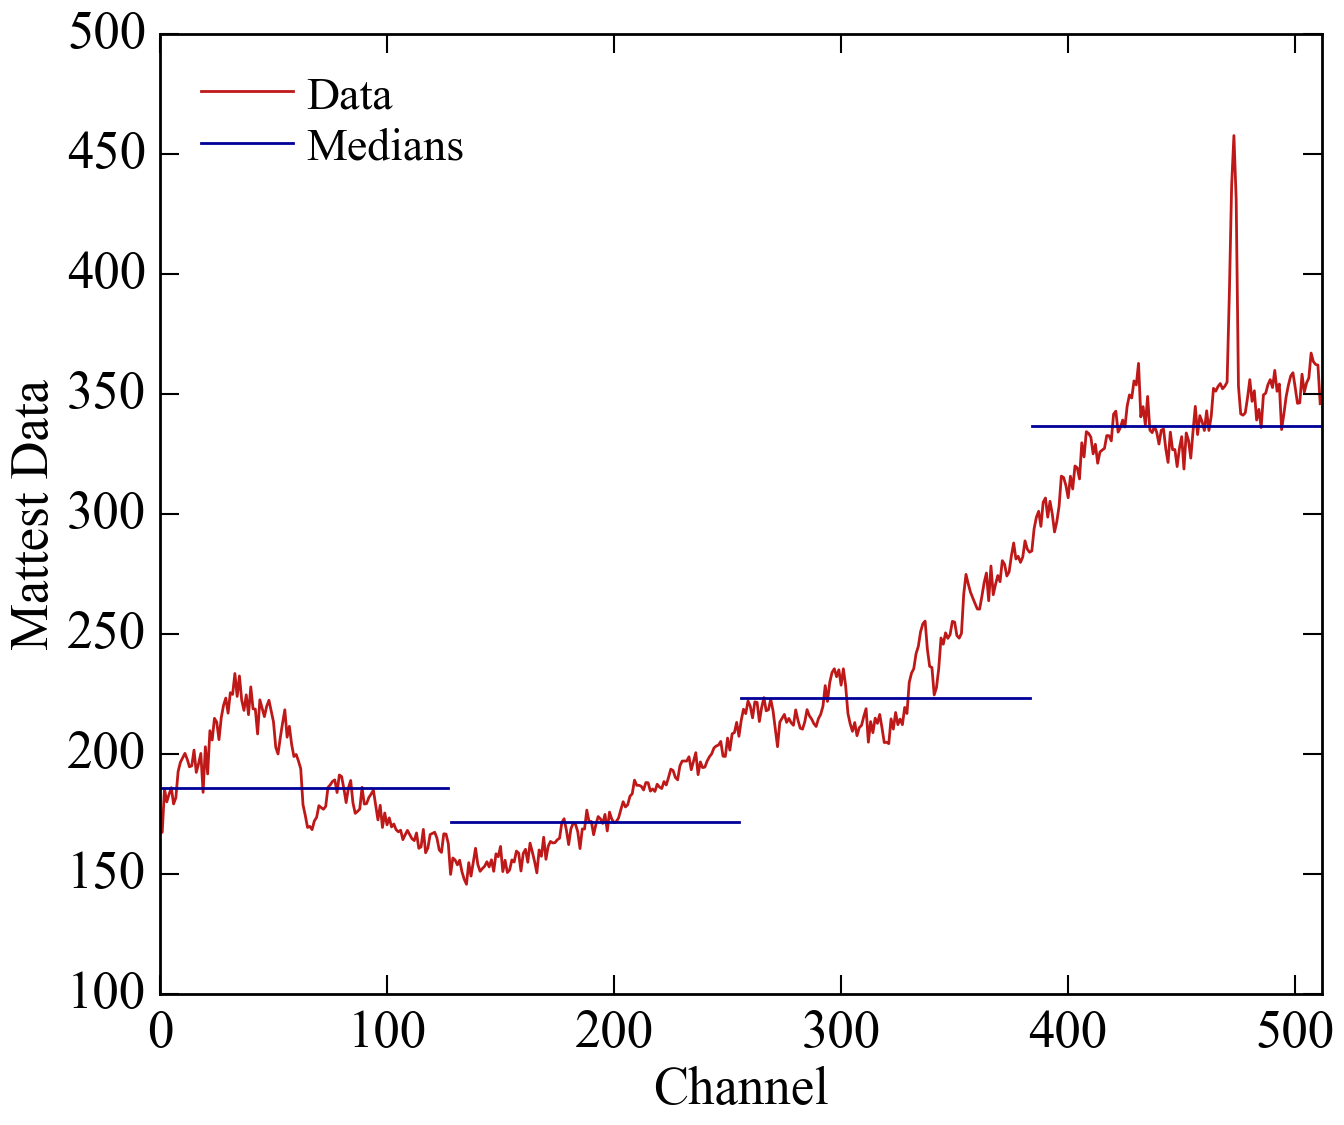

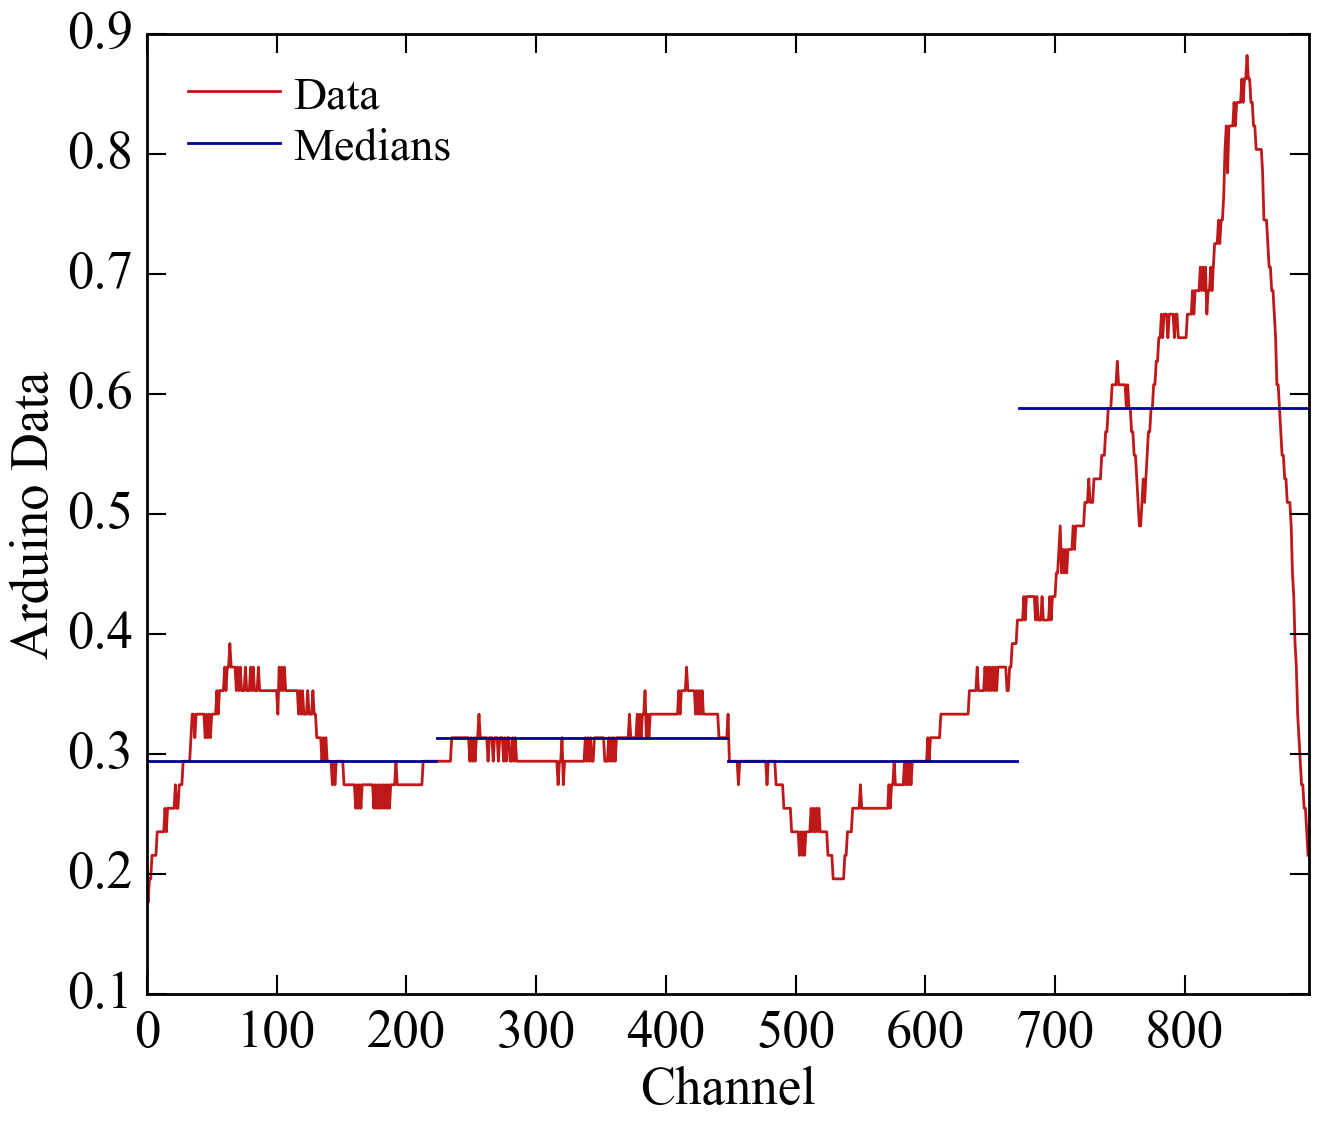

In [124]:
#Control plot
n_parts = 4
lightbar = 71
data_mattest = df.loc[lightbar]["Mattest_Corrected_Data_VEC"]
data_arduino = df.loc[lightbar]["Arduino_Data_VEC"]

for idx, data in enumerate([data_mattest, data_arduino]):
    medians = get_medians(data, n_parts)
    xticks = np.split(np.asarray(range(len(data))), n_parts)

    plt.plot(range(len(data)), data, "gcred", label="Data")
    for i in range(n_parts):
        if i == 0:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue", label = "Medians")
        else:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue")
    plt.xlabel("Channel")  
    plt.xlim(0, len(data))
    if idx == 0:
        plt.ylabel("Mattest Data")
    elif idx == 1:
        plt.ylabel("Arduino Data")
    plt.legend(loc = "upper left")
    plt.show()
    plt.close()

# Plots

# Arduino: median uniformity vs. rel std

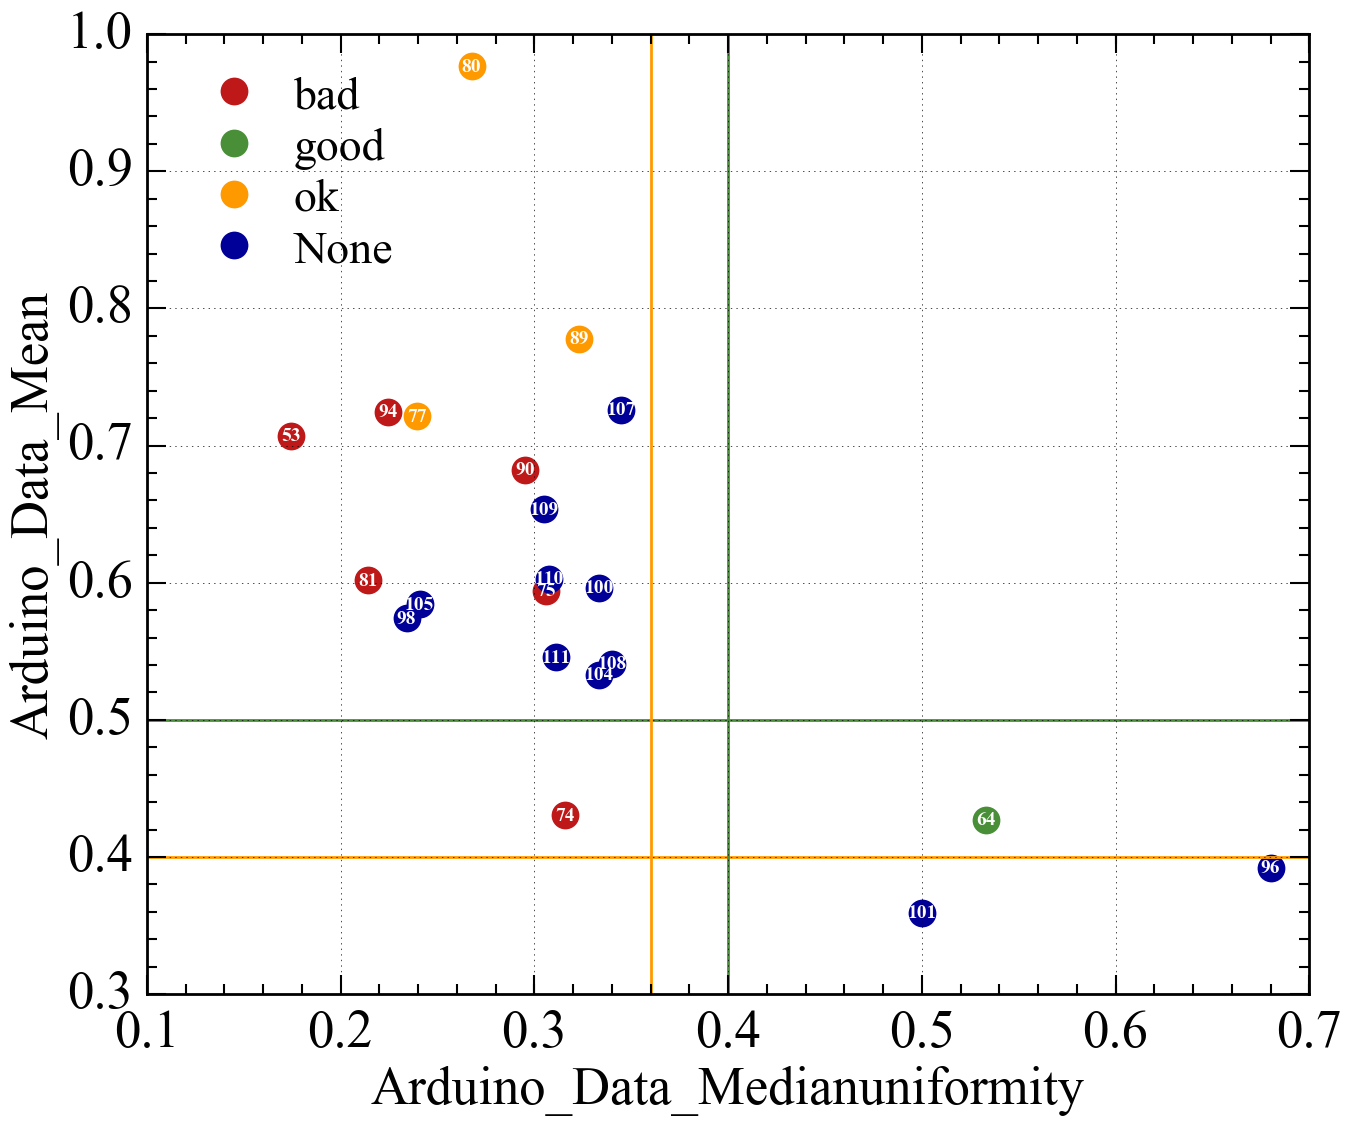

In [188]:
plot_df = df.ix[ df["In_Production"] == 0 ]
#plot_df = plot_df.ix[ df["Has_Mattest"] == 0]
plot_2D(plot_df, "Arduino_Data_Medianuniformity", "Arduino_Data_Mean")
plt.axhline(0.5, color="gcgreen")
plt.axhline(0.4, color="gcorange")
plt.axvline(0.4, color="gcgreen")
plt.axvline(0.36, color="gcorange")